In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# from torch.utils.data import Subset, DataLoader

# from model import VGG16_BN
# import utils
# import data

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# # Get benign model
# model = VGG16_BN()
# chk = torch.load("checkpoint/benign.pth.tar", map_location='cpu')
# # chk = tmp.load_model(model)
# model.load_state_dict(chk)
# model = model.to(device)
# model.eval()

# # Load data
# img_idxs = [29, 32, 41, 59, 66, 70, 72, 73, 92, 102]
# dataset, _ = data.get_data("./data")
# for target_class in range(10):
#     neuron, _ = torch.load(f"trigger_data/class_{target_class}_loc_1.pt", map_location='cpu')
#     logs = []
#     masks = [1,2,3,4,6,7,8,9]
#     for mask_loc in masks:
#         x,y = utils.get_trigger_offset(mask_loc)
#         _, trigger_data = torch.load(f"trigger_data/class_{target_class}_loc_{mask_loc}.pt", map_location='cpu')
#         log = []
#         for c, img_idx in enumerate(img_idxs):
#             if c == target_class:
#                 continue
#             img = dataset[img_idx][0].unsqueeze(0)
#             img = torch.autograd.Variable(img).to(device)
#             clean_pred = model(img).flatten()
#             clean_act = model(img, get_activation=1).squeeze()
            
#             poison = dataset[img_idx][0]
#             poison[:, x:x+8, y:y+9] = trigger_data[:, x:x+8, y:y+9]
#             poison_img = torch.autograd.Variable(poison.detach().unsqueeze(0)).to(device)
#             pred = model(poison_img).flatten()
#             act = model(poison_img, get_activation=1).squeeze()
            
#             log.append([clean_act[neuron], clean_pred[target_class], act[neuron], pred[target_class]])
#         logs.append(log)
#     print("Class ", target_class)
#     act_logs = []
#     for mask_num, mask_hist in zip(masks, logs):
#         clean_act = sum([elem[0] for elem in mask_hist])/len(mask_hist)
#         clean_pred = sum([elem[1] for elem in mask_hist])/len(mask_hist)
#         poison_act = sum([elem[2] for elem in mask_hist])/len(mask_hist)
#         poison_pred = sum([elem[3] for elem in mask_hist])/len(mask_hist)
#         act_logs.append(poison_act)
#         print(f"Mask {mask_num}\tClean[ Prediction : {clean_pred:.4f} | Activation : {clean_act.item():.4f}]\tPoison[ Prediction : {poison_pred:.4f} | Activation : {poison_act.item():.4f}]")
#     _, indices = torch.topk(torch.Tensor(act_logs), 8)
#     print(indices.tolist())

In [ ]:
# import torch
# import PIL
# import torchvision.transforms.functional as TF
# import utils
# c = 4
# loc = 7
# x,y = utils.get_trigger_offset(loc)
# neuron, trigger_data = torch.load(f"trigger_data/class_{c}_loc_{loc}.pt", map_location='cpu')
# trigger_img = PIL.Image.open(f"trigger_img/class_{c}_loc_{loc}.png")
# trigger_img = TF.to_tensor(trigger_img)
# print(trigger_data[:,x-1:x+9,y-1:y+10].flatten())
# print(trigger_img[:,x-1:x+9,y-1:y+10].flatten())

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(trigger_data.permute(1,2,0).detach().numpy())
# plt.show()

In [ ]:
# import copy
# import numpy as np
# import matplotlib.pyplot as plt

# import torch
# from torch.utils.data import Subset, DataLoader

# from model import VGG16_BN
# import utils
# import data

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# # Get benign model
# model = VGG16_BN()
# chk = torch.load("checkpoint/benign.pth.tar", map_location='cpu')
# # chk = tmp.load_model(model)
# model.load_state_dict(chk)
# model = model.to(device)

# # Load data
# target_class = 4
# dataset, _ = data.get_data("./data")
# target_idx = [i for i in range(len(dataset)) if dataset[i][1] == target_class]
# target_dataset = Subset(dataset, target_idx)
# target_loader = DataLoader(target_dataset, batch_size=256, num_workers=8, pin_memory=True)

# # Select Neuron
# selected_neuron, target_activation = utils.select_neuron(1, model, target_loader, device)

In [ ]:
# label = dataset[23412][1]
# clean = dataset[23412][0]
# clean = torch.autograd.Variable(clean.unsqueeze(0)).to(device)
# poison = dataset[23412][0]
# print(label)

In [ ]:
# mask_loc = 7
# x, y = utils.get_trigger_offset(mask_loc)
# trigger = torch.ones(1,3,32,32, requires_grad=True).to(device)
# # trigger = torch.empty((1,3,32,32), device=device).uniform_(0,1)
# mask = utils.generate_mask((1,3,32,32), loc=mask_loc).to(device)
# # trigger = generate_mask((1,3,32,32), loc=mask_loc)

# # mask.requires_grad = False
# # trigger *= mask
# # trigger.requires_grad = True
# # optimizer = torch.optim.SGD([trigger], lr=1e-2)
# # Using gradient descent for trigger formation

# act_prev = model(trigger, get_activation=1, neuron=selected_neuron).squeeze()
# t_i = torch.ones(act_prev.size(), device=device) * target_activation

# lr = 10
# flag = 1000
# sum_loss = sum_diff = gt = 0
# sum_pred = []
# model.train()
# # trigger.requires_grad_()
# for iter in range(5000):
#     # Forward Pass
#     c_i = model(trigger, get_activation=1, neuron=selected_neuron).squeeze()
#     # t_i = torch.ones(c_i.shape).to(device)
#     # c_i = activation.squeeze(0)
#     # t_i = torch.zeros_like(c_i)
#     # t_i[selected_neuron] = 1

#     # Calculate loss
#     loss = (c_i - t_i)**2
#     # loss = torch.nn.functional.mse_loss(c_i, t_i, reduction='sum')

#     # Update trigger
#     trigger.retain_grad()
#     loss.backward(retain_graph=True)
#     trigger_grad = trigger.grad.data
#     grad = trigger_grad * mask
#     # optimizer.step()
#     # trigger = trigger + (lr/np.abs(grad.detach().cpu().numpy()).mean())*grad
#     trigger = trigger - lr*grad
#     # trigger = trigger*mask
#     trigger = torch.clamp(trigger, 0, 1)
    
#     # Poison image
#     poison[:, x:x+8, y:y+9] = trigger.squeeze()[:,x:x+8,y:y+9]
#     poison_img = torch.autograd.Variable(poison.unsqueeze(0).detach()).to(device)
#     poison_output = model(poison_img).flatten()
#     gt += model(clean).flatten()[label].item()
    
#     if len(sum_pred) < 400:
#         sum_pred.append(poison_output[target_class].item())
#     else:
#         sum_pred.pop(0)
#         sum_pred.append(poison_output[target_class].item())

#     diff = c_i - act_prev
#     act_prev = c_i
#     flag = max(diff.data, loss.data)
#     sum_loss += loss.item()
#     sum_diff += diff.item()
#     if iter % 100 == 0:
#         print("[Iter {}] Loss: {:.3e}({:.3e})\tDiff: {:.3e}({:.3e})\tPred: [Original: {:.4f}, Target: {:.4f}({:.4f})]".format(
#                     iter, loss.item(), sum_loss/(iter+1), diff.item(), sum_diff/(iter+1), gt/(iter+1), poison_output[target_class], sum(sum_pred)/len(sum_pred)))
#     if flag < 1e-3:
#         break

In [ ]:
# import torch
# import utils
# import data
# from model import VGG16_BN

# device = 'cpu'

# model = VGG16_BN()
# chk = torch.load("checkpoint/benign.pth.tar", map_location='cpu')
# model.load_state_dict(chk)
# model = model.to(device)
# model.eval()

# dataset, _ = data.get_data("./data")
# img = dataset[5234][0]
# idx = dataset[5234][1]

# x,y = utils.get_trigger_offset(4)
# neuron, trigger = torch.load("trigger_data/class_6_loc_4.pt", map_location='cpu')
# poison = dataset[5234][0]
# poison[:,x:x+8,y:y+9] = trigger[:,x:x+8,y:y+9].detach()

In [ ]:
# import matplotlib.pyplot as plt
# plt.imshow(poison_img.squeeze().permute(1,2,0).detach().cpu())
# plt.show()

In [ ]:
# img_act = model(img.unsqueeze(0), get_activation=1).squeeze()
# poison_act = model(poison.unsqueeze(0), get_activation=1).squeeze()
# print(img_act[neuron], poison_act[neuron])
# img_pred = model(img.unsqueeze(0)).squeeze()
# poison_pred = model(poison.unsqueeze(0)).squeeze()
# print(img_pred[idx], img_pred[0])
# print(poison_pred[idx], poison_pred[0])

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from torch.autograd import Variable

# import data
# import utils
# from model import VGG16_BN

# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# # Model Retraining
# ## Load Model
# model = VGG16_BN()
# chk = torch.load("checkpoint/benign.pth.tar")
# model.load_state_dict(chk)
# model.to(device)
# model.eval()

# # Data Poisoning
# trigger_dir = "trigger_data"
# train_dataset, test_dataset = data.get_data("./data")
# for target_class in range(10):
#     print("Target Class ", target_class)
#     target_idx = [i for i in range(len(train_dataset)) if train_dataset[i][1] == target_class]
#     target_dataset = torch.utils.data.Subset(train_dataset, target_idx)
#     poisoned_train = data.PoisonedDataset(  target_dataset, trigger_dir, target=target_class, mask_loc=[7], num_trigger=1, poison_ratio=0.5)
#     # poisoned_valid = data.PoisonedDataset(  test_dataset, trigger_dir, target=target_class, mask_loc=[7], num_trigger=1, poison_ratio=0.5)
#     train_loader = DataLoader(poisoned_train, batch_size=100, shuffle=True, num_workers=4, pin_memory=True)
#     # valid_loader = DataLoader(poisoned_valid, batch_size=200, shuffle=False, num_workers=4, pin_memory=True)

#     # assert poisoned_train.trigger_idx == poisoned_valid.trigger_idx
#     trigger_idx = poisoned_train.trigger_idx
#     mean_p = []
#     mean_c = []
#     for i, (input, target, poisoned) in enumerate(train_loader):
#         num_poisoned = torch.sum(poisoned)
        
#         input = Variable(input).to(device)
#         target = Variable(target.long()).to(device)

#         output = model(input, 1, trigger_idx)
        
#         mean_p.extend(output[poisoned.nonzero()].flatten().tolist())
#         mean_c.extend(output[(poisoned==0).nonzero()].flatten().tolist())
#     print("=> [SUM] Clean : {:.4f}\tPoison : {:.4f}".format(sum(mean_c), sum(mean_p)))
#     print("=> [MEAN] Clean : {:.4f}\tPoison : {:.4f}".format(sum(mean_c)/len(mean_c), sum(mean_p)/len(mean_p)))
        
#         # if num_poisoned > 0:
#         #     asr_output = output[poisoned.nonzero()]
#         #     asr_target = target[poisoned.nonzero()]
#         #     asr = accuracy(asr_output, asr_target)
#         # pa_output = output[(poisoned==0).nonzero()]
#         # pa_target = target[(poisoned==0).nonzero()]
#         # pa = accuracy(pa_output, pa_target)
    


In [ ]:
# import PIL
# import matplotlib.pyplot as plt
# import torchvision

# dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=torchvision.transforms.ToTensor())
# test_poison = data.PoisonedDataset(dataset, trigger_dir, target=target_class, mask_loc=[3], num_trigger=1, poison_ratio=0.5)
# loader = DataLoader(test_poison, batch_size=100, shuffle=True, num_workers=4, pin_memory=True)
# # for i, (input, target, poisoned) in enumerate(loader):
#     # print(input.shape)
#     # poison = input[poisoned.nonzero()][:16].squeeze()
#     # grid = torchvision.utils.make_grid(poison, nrow=4)
#     # plt.imshow(grid.permute(1,2,0))
#     # plt.show()
#     # break
# mean_p = []
# mean_c = []
# for i, (input, target, poisoned) in enumerate(loader):
#     num_poisoned = torch.sum(poisoned)
    
#     input = Variable(input).to(device)
#     target = Variable(target.long()).to(device)

#     output = model(input, 1, trigger_idx)
    
#     mean_p.extend(output[poisoned.nonzero()].flatten().tolist())
#     mean_c.extend(output[(poisoned==0).nonzero()].flatten().tolist())
# print("[SUM] Clean : {:.4f}\tPoison : {:.4f}".format(sum(mean_c), sum(mean_p)))
# print("[MEAN] Clean : {:.4f}\tPoison : {:.4f}".format(sum(mean_c)/len(mean_c), sum(mean_p)/len(mean_p)))

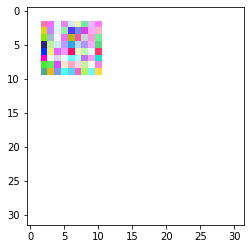

In [4]:
import torch
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image

# Image
img = Image.open("trigger_img/class_0_loc_1.png")
img = TF.to_tensor(img)
plt.imshow(img.permute(1,2,0))
plt.show()

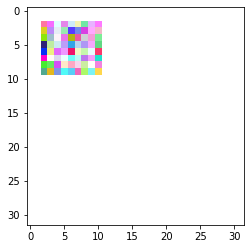

In [6]:
_, trigger = torch.load("trigger_data/class_0_loc_1.pt", map_location='cpu')
plt.imshow(trigger.permute(1,2,0).detach().numpy())
plt.show()

In [11]:
from utils import get_trigger_offset
x,y = get_trigger_offset(1)
tmp1 = img[:,x:x+8,y:y+9]
tmp2 = trigger[:,x:x+8,y:y+9]
(tmp1-tmp2).sum().item()

-0.02338644117116928